In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
pd.pandas.set_option('display.max_columns',None)

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [4]:
train_data = pd.read_csv("../data/train_processed_data.csv")
train_data.shape

(6983, 15)

In [5]:
from sklearn import metrics
def model_compare(model_name,model,y_test,y_pred,y_score, roc_auc = None):
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : roc_auc
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model_name] 
    return df_metrics

In [6]:
x = train_data.drop(['Churn','customerID'],axis =1).values
y = train_data['Churn'].values
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.2, random_state=303)

## DecisionTree

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
model_dt = DecisionTreeClassifier(random_state=303)
np.random.seed(303)
# start = time.time()
param_dist = {'max_depth': [2, 3, 4, 5, 6, 7],
              'min_samples_leaf':[100,200,70, 30],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_dt, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 100}


In [8]:
model_dt = DecisionTreeClassifier(random_state=303,
                                  max_depth=6, 
                                  criterion = 'gini', 
                                  min_samples_leaf=100 )
model_dt.fit(x_train, y_train)
model_dt_score_train = model_dt.score(x_train, y_train)
print("Training score: ",model_dt_score_train)
model_dt_score_test = model_dt.score(x_test, y_test)
print("Testing score: ",model_dt_score_test)

Training score:  0.8043322592194773
Testing score:  0.7888332140300645


In [9]:
y_pred = model_dt.predict(x_test)
# Model Accuracy
print (model_dt.score(x_test, y_test))

0.7888332140300645


In [10]:
y_pred = model_dt.predict(x_test)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr_dt, tpr_dt)
y_score = accuracy_score(y_test, y_pred)
metrix_dt = model_compare("Decision Tree",model_dt, y_test, y_pred, y_score, roc_auc  )
metrix_dt

,Decision Tree
Accuracy,0.788833
Precision,0.648221
Recall,0.443243
F1 Score,0.526485
ROC AUC,0.678292


## Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
model_rf = RandomForestClassifier(random_state=303)

In [14]:
param_dist = {'max_depth': [3,4,5,7,8],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 7, 'max_features': None}


In [13]:
model_rf.set_params(criterion    = 'gini',
                    max_features = None, 
                    max_depth    = 7,
                    bootstrap    = True
                   )

RandomForestClassifier(max_depth=7, max_features=None, random_state=303)

In [32]:
model_rf.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 2000
max_estimators = 2500

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    model_rf.set_params(n_estimators=i)
    model_rf.fit(x_train, y_train)

    oob_error = 1 - model_rf.oob_score_
    error_rate[i] = oob_error

oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

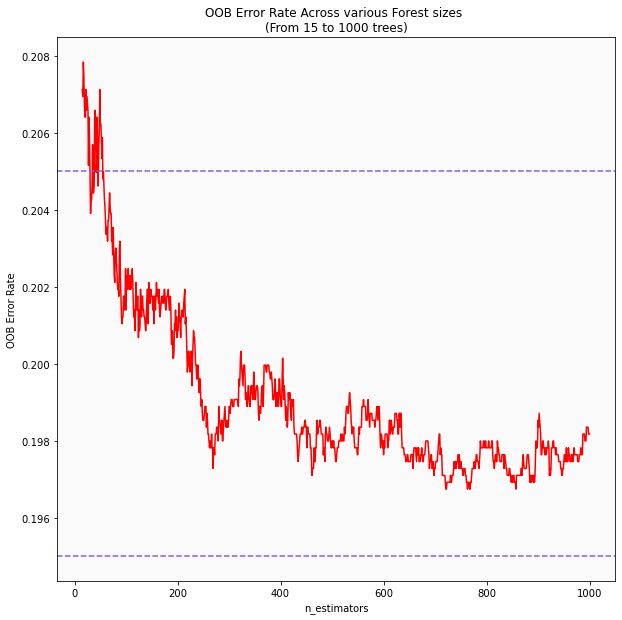

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.205, color='#875FDB',linestyle='--')
plt.axhline(0.195, color='#875FDB',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 1000 to 2000 trees)')

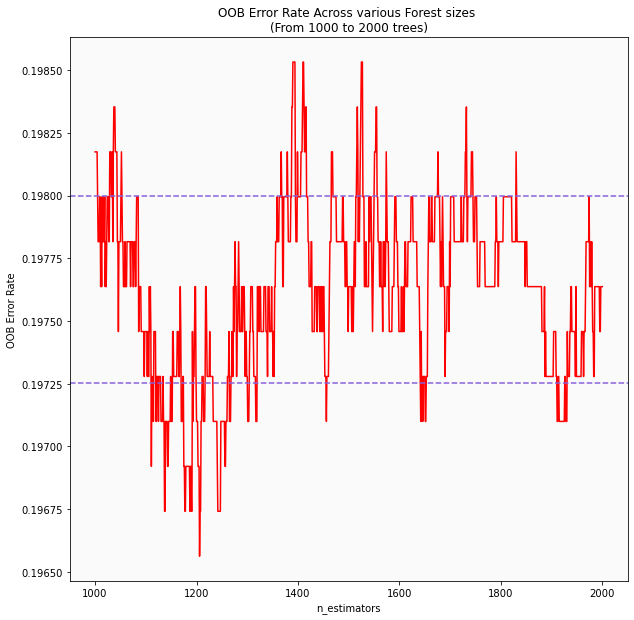

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.198, color='#875FDB',linestyle='--')
plt.axhline(0.197251, color='#875FDB',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 1000 to 2000 trees)')

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 2000 to 2500 trees)')

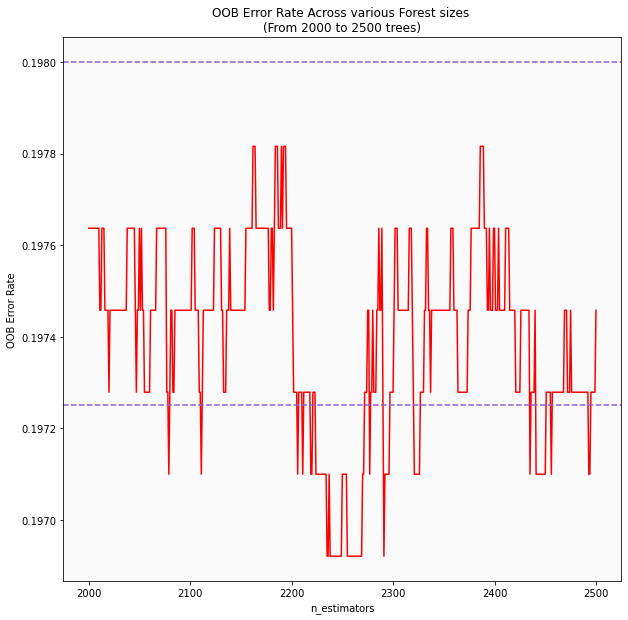

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',color = 'red')
plt.axhline(0.198, color='#875FDB',linestyle='--')
plt.axhline(0.197251, color='#875FDB',linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 2000 to 2500 trees)')

In [14]:
model_rf.set_params(n_estimators=1150,
                    bootstrap = True,
                    warm_start=False, 
                    oob_score=False)

RandomForestClassifier(max_depth=7, max_features=None, n_estimators=1150,
                       random_state=303)

In [15]:
model_rf.fit(x_train, y_train)
prediction_test = model_rf.predict(x_test)
y_score= metrics.accuracy_score(y_test, prediction_test)
y_pred= model_rf.predict(x_test)
#########################################################
y_pred = model_rf.predict_proba(x_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc_rf = auc(fpr_dt, tpr_dt)
#########################################################
metrix_rf = model_compare("Random Forest",model_rf, y_test, prediction_test, y_score , roc_auc_rf )
metrix_rf

,Random Forest
Accuracy,0.788833
Precision,0.635379
Recall,0.475676
F1 Score,0.544049
ROC AUC,0.832689


## AdaBoost

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

In [17]:
model_ada = AdaBoostClassifier()

In [ ]:
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500, 750, 1200]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model_ada, param_grid=grid, n_jobs=1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(x_train, y_train)
print('Best Parameters using grid search: \n', grid_result.best_params_)

In [18]:
model_ada.set_params(learning_rate    = 0.1,
                     n_estimators = 1150
                    )

AdaBoostClassifier(learning_rate=0.1, n_estimators=1150)

In [19]:
model_ada.fit(x_train, y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=1150)

In [20]:
y_pred=model_ada.predict(x_test)
y_score = metrics.accuracy_score(y_test, y_pred)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc_ada = auc(fpr_dt, tpr_dt)
metrix_ada = model_compare("Ada Boost", model_ada, y_test, y_pred, y_score, roc_auc_ada )
metrix_ada

,Ada Boost
Accuracy,0.797423
Precision,0.654804
Recall,0.497297
F1 Score,0.565284
ROC AUC,0.701424


## XGBoost

In [21]:
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [22]:
scaler = StandardScaler()
scaler.fit(x)
x1 = scaler.transform(x)

In [23]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y,test_size =0.2, random_state=303)

In [24]:
xgboost_best = xgb.XGBClassifier(n_jobs = 1
                                 ,objective = 'binary:logistic'
                                 ,colsample_bytree = 1.0
                                  ,gamma = 0.1
                                  ,learning_rate = 0.1
                                  ,max_depth = 5
                                  ,min_child_weight = 5
                                  ,n_estimators = 750
                                  ,subsample = 1.0)

In [25]:
xgboost_best.fit(x1_train,y1_train)

[16:26:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=750, n_jobs=1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
y_pred = xgboost_best.predict(x1_test)
y_score = metrics.accuracy_score(y1_test, y_pred)
fpr_dt, tpr_dt, _ = roc_curve(y1_test, y_pred)
roc_auc_xgboost = auc(fpr_dt, tpr_dt)
metrix_xgboost = model_compare("Xg Boost", model_ada, y_test, y_pred, y_score, roc_auc_xgboost )
metrix_xgboost

,Xg Boost
Accuracy,0.782391
Precision,0.610000
Recall,0.494595
F1 Score,0.546269
ROC AUC,0.690335


## SVM

In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x1 = scaler.transform(x)

In [28]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y,test_size =0.2, random_state=303)

In [29]:
from sklearn.svm import SVC

In [ ]:
tuned_parameters = {
    'C': (np.arange(0.1,1,0.1)) , 
    'kernel': ['linear','rbf','poly'],
    'degree': [2,3,4] ,
    'gamma':[0.01,0.02,0.03,0.04,0.05] 
                   }
model_svc= SVC()
model_svm = GridSearchCV(model_svc, tuned_parameters,cv=10,scoring='accuracy')
model_svm.fit(x_train, y_train)
print(model_svm.best_score_)
print(model_svm.best_params_)

In [44]:
model_svc = SVC(kernel='poly',gamma=0.05, degree=3, C=0.9 )
model_svc.fit(x1_train,y1_train)
y_pred=model_svc.predict(x1_test)
print('Accuracy Score:')
print(metrics.accuracy_score(y1_test,y_pred))
y_pred = model_svc.predict(x1_test)
y_score = metrics.accuracy_score(y1_test, y_pred)
#########################################################
# y_pred = model_svm.predict_proba(x_test)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
roc_auc_svm = auc(fpr_dt, tpr_dt)
#########################################################
metrix_svm = model_compare("SVM poly", model_svc, y_test, y_pred, y_score, roc_auc_svm )
metrix_svm

Accuracy Score:
0.788117394416607


,SVM poly
Accuracy,0.788117
Precision,0.720238
Recall,0.327027
F1 Score,0.449814
ROC AUC,0.640631


In [46]:
metrics_bn_new = pd.concat([metrix_dt, metrix_rf, metrix_svm, metrix_ada, metrix_xgboost], axis=1) #  metrix_nb,  metrix_GB,
metrics_bn_new

,Decision Tree,Random Forest,SVM poly,Ada Boost,Xg Boost
Accuracy,0.788833,0.788833,0.788117,0.797423,0.782391
Precision,0.648221,0.635379,0.720238,0.654804,0.610000
Recall,0.443243,0.475676,0.327027,0.497297,0.494595
F1 Score,0.526485,0.544049,0.449814,0.565284,0.546269
ROC AUC,0.678292,0.832689,0.640631,0.701424,0.690335
